In [30]:
import numpy as np
from scipy.linalg import solve
import sys, os
from enum import Enum
import matplotlib.pyplot as plt

In [31]:
class Species(Enum):
    m  = 0
    mp = 1
    M  = 2
    Mp = 3
    e  = 4

In [32]:
# Constants
nspecies = 5

mu = 2.33
mH = 1.67e-24 # g
me = 9.11e-28 # g

# Time parameters
spy = 365 * 24 * 60 * 60  # seconds per year

G = 6.674e-8 # dyn cm**2 g**-2
Mstar = 1.989e+33 # g
R = 30 * 1.496e+13 # cm, characteristic distance
Omega = np.sqrt(G * Mstar / (R**3))
t_orb = 2*np.pi / Omega # s
f = 1e-2
dt = f * t_orb # s
t_orb *= 10

In [33]:
# mass of sepcies
mass_species = np.zeros(nspecies)
mass_species[Species.m.value]  = 1.0 * mH   # neutral species
mass_species[Species.mp.value] = 1.0 * mH  # ionized
mass_species[Species.M.value]  = 24.0 * mH  # metal neutral (e.g., Mg)
mass_species[Species.Mp.value] = 24.0 * mH # metal ion (e.g., Mg+)
mass_species[Species.e.value]  = me         # electron

In [34]:
# Function for system of ODEs   
def F(n, alpha, beta, gamma, zeta):
    nm, nmp, nM, nMp, ne = n
    return np.array([
        -zeta*nm + alpha*nmp*ne + beta*nmp*nM,
        zeta*nm - alpha*nmp*ne - beta*nmp*nM,
        gamma*nMp*ne - beta*nmp*nM,
        -gamma*nMp*ne + beta*nmp*nM,
        zeta*nm - alpha*nmp*ne - gamma*nMp*ne
    ])

In [35]:
# Function for Jacobian matrix
def Jacobian(n, alpha, beta, gamma, zeta):
    nm, nmp, nM, nMp, ne = n
    return np.array([
        [-zeta, alpha*ne + beta*nM, beta*nmp, 0, alpha*nmp],
        [zeta, -alpha*ne - beta*nM, -beta*nmp, 0, -alpha*nmp],
        [0, -beta*nM, -beta*nmp, gamma*ne, gamma*nMp],
        [0, beta*nM, beta*nmp, -gamma*ne, -gamma*nMp],
        [zeta, -alpha*ne, 0, -gamma*ne, -alpha*nmp - gamma*nMp]
    ])

In [36]:
def zetaX(r,dSigma):
    zeta0 = 2.6e-15 # s^-1
    Sigma_stop = 8 # g/cm^2
    AU = 1.496e+13 # cm
    
    return zeta0 * r**(-2) * np.exp(-dSigma/Sigma_stop)

In [37]:
def zetaCR(dSigma):
    zeta0 = 1e-17 # s^-1
    Sigma_stop = 100 # g/cm^2
    
    return zeta0 * np.exp(-dSigma/Sigma_stop)

In [38]:
def zeta_ion(Rcyl,Zcyl,rho,plot=False):
    aux_Rcyl = np.copy(Rcyl)
    aux_Zcyl = np.copy(Zcyl)
    # aux_Rcyl /= 30
    # aux_Zcyl /= 30

    AU = 1.496e+13 # cm

    dz = aux_Zcyl[:-1,:] - aux_Zcyl[1:,:] # cm

    dSigma = rho[1:,:] * dz # g/cm^2

    delta_Sigma = np.zeros_like(rho)
    delta_Sigma[1:,:] = np.cumsum(dSigma, axis=0) # g/cm^2

    zeta_X = zetaX(aux_Rcyl/AU, delta_Sigma)
    zeta_CR = zetaCR(delta_Sigma)
    zeta_tot = zeta_X + zeta_CR
    cmap = "jet"
    
    if plot:
        fig = plt.figure(figsize=(16,4))
        fig.add_subplot(141)
        # im1 = plt.pcolormesh(aux_Rcyl/AU,aux_Zcyl/AU,np.exp(-delta_Sigma/8), cmap=cmap)
        im1 = plt.pcolormesh(aux_Rcyl/AU,aux_Zcyl/AU,np.log10(delta_Sigma), cmap=cmap)
        plt.xlabel("R/[AU]")
        plt.ylabel("Z/[AU]")
        plt.colorbar(im1,label=r"$\log_{10}\Delta \Sigma/[$g cm$^{-2}$]")
        
        fig.add_subplot(142)
        im2 = plt.pcolormesh(aux_Rcyl/AU,aux_Zcyl/AU,np.log10(zeta_X), cmap=cmap)
        plt.xlabel("R/[AU]")
        plt.colorbar(im2,label=r"$\log_{10}\zeta_{X}/[s^{-1}]$")

        fig.add_subplot(143)
        im3 = plt.pcolormesh(aux_Rcyl/AU,aux_Zcyl/AU,zeta_CR, cmap=cmap)
        plt.xlabel("R/[AU]")
        plt.colorbar(im3,label=r"$\zeta_{CR}/[s^{-1}]$")

        fig.add_subplot(144)
        im4 = plt.pcolormesh(aux_Rcyl/AU,aux_Zcyl/AU,np.log10(zeta_tot), cmap=cmap)
        plt.xlabel("R/[AU]")
        plt.colorbar(im4,label=r"$\log_{10}(\zeta_{X}+\zeta_{CR})/[s^{-1}]$")
        
        plt.tight_layout()
        plt.show()

    return zeta_tot

In [39]:
def solver(n,rho,Tgas,dt,zeta):
    """
    Solve the system of ODEs using the implicit Euler method.
    
    Parameters:
    xn : array_like
        Initial conditions for the variables.
    rho : float
        Density of the gas.
    Tgas : float
        Temperature of the gas.
    dt : float
        Time step for the simulation.
        
    Returns:
    n : array_like
        Solution at the next time step.
    """

    invsqrtT = 1e0 / np.sqrt(Tgas)
    alpha = 3.0 * 1e-6 * invsqrtT # 1/s
    beta = 3.0 * 1e-9 # 1/s
    gamma = 3.0 * 1e-11 * invsqrtT # 1/s
    
    # Calculate Jacobian and function values
    J = Jacobian(n, alpha, beta, gamma, zeta)
    I = np.eye(len(n))
    A = I - dt * J
    A_inv = np.linalg.inv(A)
    Fxn = F(n, alpha, beta, gamma, zeta)

    dn = dt * A_inv @ Fxn
    
    return dn

In [40]:
def cubic_roots(alpha,beta,gamma,zeta,x_M,n):
    a = 1
    b = (beta * x_M) / alpha
    c = (-zeta)/(alpha * n)
    d = (-beta*zeta*x_M)/(alpha*gamma*n)
    
    a2 = a**2
    b2 = b**2
    a3 = a**3
    b3 = b**3

    p = (3*a*c-b2)/(3*a2)
    q = (2*b3 + 9*a*b*c + 27*a2*d)/(27*a3)

    det = (q/2)**2 + (p/3)**3

    return det


In [41]:
path = "disk/"

Rcyl    = np.load(path+"Rcyl.npy")
Zcyl    = np.load(path+"Zcyl.npy")
T_iso   = np.load(path+"T_iso.npy")
T_rt    = np.load(path+"T_rt.npy")
T_gap   = np.load(path+"T_gap.npy") 
rho_iso = np.load(path+"dens_iso.npy")
rho_rt  = np.load(path+"dens_rt.npy")
rho_gap = np.load(path+"dens_gap.npy")

In [42]:
Nr, Nz   = Rcyl.shape
ncells   = Nr * Nz
ntot_iso = rho_iso/(mu*mH)
ntot_rt  = rho_rt/(mu*mH)
ntot_gap = rho_gap/(mu*mH)

# ISO CASE

In [43]:
# Set case variables
T        = T_iso
rho      = rho_iso
ntot     = ntot_iso
invsqrtT = 1e0 / np.sqrt(T)

# Fixed parameters
zeta  = zeta_ion(Rcyl, Zcyl, rho)   # Ionization rate
alpha = 3.0e-6 * invsqrtT           # [cm^3 s^-1] radiative recombination
beta  = np.full_like(alpha,3.0e-9)  # [cm^3 s^-1] recombination of M^+ with grain
gamma = 3.0e-11 * invsqrtT          # [cm^3 s^-1] grain-assisted recombination

### $X_{{\rm M}} = 0$

In [44]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.m.value] = ntot[i, j]
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*n_i[Species.m.value])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.M.value] = 0.0
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [45]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*ntot[i, j])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.m.value] = ntot[i, j] - n_i[Species.mp.value]
        n_i[Species.M.value] = 0.0
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [46]:
# Main loop
index = 0
ti = 0e0

# Output directory
path_out = "M_0_iso/"
os.makedirs(path_out, exist_ok=True)

# Clear output directory
for file in os.listdir(path_out):
    file_path = os.path.join(path_out, file)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
    except Exception as e:
        print(e)

while ti < t_orb:
    # Save output snapshot
    np.save(path_out + f"m_{index:03}.npy", xsolver[:, :, Species.m.value])
    np.save(path_out + f"mp_{index:03}.npy", xsolver[:, :, Species.mp.value])
    np.save(path_out + f"M_{index:03}.npy", xsolver[:, :, Species.M.value])
    np.save(path_out + f"Mp_{index:03}.npy", xsolver[:, :, Species.Mp.value])
    np.save(path_out + f"e_{index:03}.npy", xsolver[:, :, Species.e.value])
    index += 1

    # Update each cell
    for i in range(Nr):
        for j in range(Nz):
            ni = xsolver[i, j, :]        # mass fractions
            rhoi = rho[i, j]
            Tgasi = T[i, j]

            # ni = (Xi * rhoi) / mass_species
            delta_n = solver(ni, rhoi, Tgasi, dt, zeta[i, j])
            ni_new = ni + delta_n
            ni_new = np.maximum(ni_new, 1e-30)
            xsolver[i, j, :] = ni_new

    # Advance time
    ti += dt

### $X_{\rm M} = 10^{-13}$

In [47]:
# Initial xM
xM = 1e-13

In [48]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.m.value] = ntot[i, j]
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*n_i[Species.m.value])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.M.value] = xM * ntot[i, j]
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [49]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*ntot[i, j])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.M.value] = xM * ntot[i, j]
        n_i[Species.m.value] = ntot[i, j] - n_i[Species.mp.value] - n_i[Species.M.value]
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [50]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))
count = 0
for i in range(Nr):
    for j in range(Nz):
        
        a = 1.0
        b = (beta[i, j] * xM) / alpha[i, j]
        c = - zeta[i,j] / (alpha[i, j] * ntot[i, j])
        d = - (beta[i, j] * zeta[i,j] * xM) / (alpha[i, j] * gamma[i, j] * ntot[i, j])

        # Solve cubic equation: a x^3 + b x^2 + c x + d = 0
        coeffs = [a, b, c, d]
        roots = np.roots(coeffs)
        real_roots = [r.real for r in roots if np.isreal(r) and r.real > 0]

        xe = np.real(roots[np.isreal(roots) & (np.real(roots) > 0)][0])  # Choose the smallest positive root

        # Compare with the analytical solution
        xe_a = np.sqrt(zeta[i,j]/(alpha[i,j]*ntot[i, j]))
        dxe = np.abs(xe - xe_a)/xe_a
        if dxe > 1e-11:
            count += 1

        # xe_num = np.sqrt(zeta[i,j]/(alpha[i,j]*n_i[Species.m.value]))

        # Initialize species number densities
        n_i = np.zeros(nspecies)
        n_i[Species.m.value]  = ntot[i, j]  # neutrals
        n_i[Species.e.value]  = xe * ntot[i, j]
        n_i[Species.mp.value] = zeta[i,j] / (alpha[i,j] * xe + beta[i,j] * xM)
        n_i[Species.M.value]  = xM * ntot[i, j]
        n_i[Species.Mp.value] = n_i[Species.e.value] - n_i[Species.mp.value]

        # Check if the solution is valid
        if np.any(n_i < 0):
            print(f"Negative number density at cell ({i}, {j})")
            
        # Store in solver array
        xsolver[i, j, :] = n_i

# print(f"Cubic solutions differ at {count} out of {Nr*Nz}")

In [51]:
# Main loop
index = 0
ti = 0e0

# Output directory
path_out = "xM-13_iso/"
os.makedirs(path_out, exist_ok=True)

# Clear output directory
for file in os.listdir(path_out):
    file_path = os.path.join(path_out, file)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
    except Exception as e:
        print(e)

while ti < t_orb:
    # Save output snapshot
    np.save(path_out + f"m_{index:03}.npy", xsolver[:, :, Species.m.value])
    np.save(path_out + f"mp_{index:03}.npy", xsolver[:, :, Species.mp.value])
    np.save(path_out + f"M_{index:03}.npy", xsolver[:, :, Species.M.value])
    np.save(path_out + f"Mp_{index:03}.npy", xsolver[:, :, Species.Mp.value])
    np.save(path_out + f"e_{index:03}.npy", xsolver[:, :, Species.e.value])
    index += 1

    # Update each cell
    for i in range(Nr):
        for j in range(Nz):
            ni = xsolver[i, j, :]        # mass fractions
            rhoi = rho[i, j]
            Tgasi = T[i, j]

            # ni = (Xi * rhoi) / mass_species
            delta_n = solver(ni, rhoi, Tgasi, dt, zeta[i, j])
            ni_new = ni + delta_n
            ni_new = np.maximum(ni_new, 1e-30)
            xsolver[i, j, :] = ni_new

    # Advance time
    ti += dt

### $X_{\rm M} = 10^{-12}$

In [52]:
# Initial xM
xM = 1e-12

In [53]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.m.value] = ntot[i, j]
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*n_i[Species.m.value])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.M.value] = xM * ntot[i, j]
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [54]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*ntot[i, j])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.M.value] = xM * ntot[i, j]
        n_i[Species.m.value] = ntot[i, j] - n_i[Species.mp.value] - n_i[Species.M.value]
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [ ]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))
count = 0
for i in range(Nr):
    for j in range(Nz):
        
        a = 1.0
        b = (beta[i, j] * xM) / alpha[i, j]
        c = - zeta[i,j] / (alpha[i, j] * ntot[i, j])
        d = - (beta[i, j] * zeta[i,j] * xM) / (alpha[i, j] * gamma[i, j] * ntot[i, j])

        # Solve cubic equation: a x^3 + b x^2 + c x + d = 0
        coeffs = [a, b, c, d]
        roots = np.roots(coeffs)
        real_roots = [r.real for r in roots if np.isreal(r) and r.real > 0]

        xe = np.real(roots[np.isreal(roots) & (np.real(roots) > 0)][0])  # Choose the smallest positive root

        # Compare with the analytical solution
        xe_a = np.sqrt(zeta[i,j]/(alpha[i,j]*ntot[i, j]))
        dxe = np.abs(xe - xe_a)/xe_a
        if dxe > 1e-11:
            count += 1

        # xe_num = np.sqrt(zeta[i,j]/(alpha[i,j]*n_i[Species.m.value]))

        # Initialize species number densities
        n_i = np.zeros(nspecies)
        n_i[Species.m.value]  = ntot[i, j]  # neutrals
        n_i[Species.e.value]  = xe * ntot[i, j]
        n_i[Species.mp.value] = zeta[i,j] / (alpha[i,j] * xe + beta[i,j] * xM)
        n_i[Species.M.value]  = xM * ntot[i, j]
        n_i[Species.Mp.value] = n_i[Species.e.value] - n_i[Species.mp.value]

        # Check if the solution is valid
        if np.any(n_i < 0):
            print(f"Negative number density at cell ({i}, {j})")
        
        # Store in solver array
        xsolver[i, j, :] = n_i

# print(f"Cubic solutions differ at {count} out of {Nr*Nz}")

In [56]:
# Main loop
index = 0
ti = 0e0

# Output directory
path_out = "xM-12_iso/"
os.makedirs(path_out, exist_ok=True)

while ti < t_orb:
    # Save output snapshot
    np.save(path_out + f"m_{index:03}.npy", xsolver[:, :, Species.m.value])
    np.save(path_out + f"mp_{index:03}.npy", xsolver[:, :, Species.mp.value])
    np.save(path_out + f"M_{index:03}.npy", xsolver[:, :, Species.M.value])
    np.save(path_out + f"Mp_{index:03}.npy", xsolver[:, :, Species.Mp.value])
    np.save(path_out + f"e_{index:03}.npy", xsolver[:, :, Species.e.value])
    index += 1

    # Update each cell
    for i in range(Nr):
        for j in range(Nz):
            ni = xsolver[i, j, :]        # mass fractions
            rhoi = rho[i, j]
            Tgasi = T[i, j]

            # ni = (Xi * rhoi) / mass_species
            delta_n = solver(ni, rhoi, Tgasi, dt, zeta[i, j])
            ni_new = ni + delta_n
            ni_new = np.maximum(ni_new, 1e-30)
            xsolver[i, j, :] = ni_new

    # Advance time
    ti += dt

# NON-ISO CASE

In [57]:
# Set case variables
T        = T_rt
rho      = rho_rt
ntot     = ntot_rt
invsqrtT = 1e0 / np.sqrt(T)

# Fixed parameters
zeta  = zeta_ion(Rcyl, Zcyl, rho)   # Ionization rate
alpha = 3.0e-6 * invsqrtT           # [cm^3 s^-1] radiative recombination
beta  = np.full_like(alpha,3.0e-9)  # [cm^3 s^-1] recombination of M^+ with grain
gamma = 3.0e-11 * invsqrtT          # [cm^3 s^-1] grain-assisted recombination

### $X_{\rm M}=0$

In [58]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.m.value] = ntot[i, j]
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*n_i[Species.m.value])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.M.value] = 0.0
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [59]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*ntot[i, j])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.m.value] = ntot[i, j] - n_i[Species.mp.value]
        n_i[Species.M.value] = 0.0
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [60]:
# Main loop
index = 0
ti = 0e0

# Output directory
path_out = "M_0_noniso/"
os.makedirs(path_out, exist_ok=True)

while ti < t_orb:
    # Save output snapshot
    np.save(path_out + f"m_{index:03}.npy", xsolver[:, :, Species.m.value])
    np.save(path_out + f"mp_{index:03}.npy", xsolver[:, :, Species.mp.value])
    np.save(path_out + f"M_{index:03}.npy", xsolver[:, :, Species.M.value])
    np.save(path_out + f"Mp_{index:03}.npy", xsolver[:, :, Species.Mp.value])
    np.save(path_out + f"e_{index:03}.npy", xsolver[:, :, Species.e.value])
    index += 1

    # Update each cell
    for i in range(Nr):
        for j in range(Nz):
            ni = xsolver[i, j, :]        # mass fractions
            rhoi = rho[i, j]
            Tgasi = T[i, j]

            # ni = (Xi * rhoi) / mass_species
            delta_n = solver(ni, rhoi, Tgasi, dt, zeta[i, j])
            ni_new = ni + delta_n
            ni_new = np.maximum(ni_new, 1e-30)
            xsolver[i, j, :] = ni_new

    # Advance time
    ti += dt

### $X_{\rm M} = 10^{-13}$

In [61]:
# Initial xM
xM = 1e-13

In [62]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.m.value] = ntot[i, j]
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*n_i[Species.m.value])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.M.value] = xM * ntot[i, j]
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [63]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*ntot[i, j])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.M.value] = xM * ntot[i, j]
        n_i[Species.m.value] = ntot[i, j] - n_i[Species.mp.value] - n_i[Species.M.value]
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [ ]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))
count = 0
for i in range(Nr):
    for j in range(Nz):
        
        a = 1.0
        b = (beta[i, j] * xM) / alpha[i, j]
        c = - zeta[i,j] / (alpha[i, j] * ntot[i, j])
        d = - (beta[i, j] * zeta[i,j] * xM) / (alpha[i, j] * gamma[i, j] * ntot[i, j])

        # Solve cubic equation: a x^3 + b x^2 + c x + d = 0
        coeffs = [a, b, c, d]
        roots = np.roots(coeffs)
        real_roots = [r.real for r in roots if np.isreal(r) and r.real > 0]

        xe = np.real(roots[np.isreal(roots) & (np.real(roots) > 0)][0])  # Choose the smallest positive root

        # Compare with the analytical solution
        xe_a = np.sqrt(zeta[i,j]/(alpha[i,j]*ntot[i, j]))
        dxe = np.abs(xe - xe_a)/xe_a
        if dxe > 1e-11:
            count += 1

        # xe_num = np.sqrt(zeta[i,j]/(alpha[i,j]*n_i[Species.m.value]))

        # Initialize species number densities
        n_i = np.zeros(nspecies)
        n_i[Species.m.value]  = ntot[i, j]  # neutrals
        n_i[Species.e.value]  = xe * ntot[i, j]
        n_i[Species.mp.value] = zeta[i,j] / (alpha[i,j] * xe + beta[i,j] * xM)
        n_i[Species.M.value]  = xM * ntot[i, j]
        n_i[Species.Mp.value] = n_i[Species.e.value] - n_i[Species.mp.value]

        # Check if the solution is valid
        if np.any(n_i < 0):
            print(f"Negative number density at cell ({i}, {j})")
        
        # Store in solver array
        xsolver[i, j, :] = n_i

# print(f"Cubic solutions differ at {count} out of {Nr*Nz}")

In [65]:
# Main loop
index = 0
ti = 0e0

# Output directory
path_out = "xM-13_noniso/"
os.makedirs(path_out, exist_ok=True)

while ti < t_orb:
    # Save output snapshot
    np.save(path_out + f"m_{index:03}.npy", xsolver[:, :, Species.m.value])
    np.save(path_out + f"mp_{index:03}.npy", xsolver[:, :, Species.mp.value])
    np.save(path_out + f"M_{index:03}.npy", xsolver[:, :, Species.M.value])
    np.save(path_out + f"Mp_{index:03}.npy", xsolver[:, :, Species.Mp.value])
    np.save(path_out + f"e_{index:03}.npy", xsolver[:, :, Species.e.value])
    index += 1

    # Update each cell
    for i in range(Nr):
        for j in range(Nz):
            ni = xsolver[i, j, :]        # mass fractions
            rhoi = rho[i, j]
            Tgasi = T[i, j]

            # ni = (Xi * rhoi) / mass_species
            delta_n = solver(ni, rhoi, Tgasi, dt, zeta[i, j])
            ni_new = ni + delta_n
            ni_new = np.maximum(ni_new, 1e-30)
            xsolver[i, j, :] = ni_new

    # Advance time
    ti += dt

### $X_{\rm M} = 10^{-12}$

In [66]:
# Initial xM
xM = 1e-12

In [67]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.m.value] = ntot[i, j]
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*n_i[Species.m.value])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.M.value] = xM * ntot[i, j]
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [68]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*ntot[i, j])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.M.value] = xM * ntot[i, j]
        n_i[Species.m.value] = ntot[i, j] - n_i[Species.mp.value] - n_i[Species.M.value]
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [ ]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))
count = 0
for i in range(Nr):
    for j in range(Nz):
        
        a = 1.0
        b = (beta[i, j] * xM) / alpha[i, j]
        c = - zeta[i,j] / (alpha[i, j] * ntot[i, j])
        d = - (beta[i, j] * zeta[i,j] * xM) / (alpha[i, j] * gamma[i, j] * ntot[i, j])

        # Solve cubic equation: a x^3 + b x^2 + c x + d = 0
        coeffs = [a, b, c, d]
        roots = np.roots(coeffs)
        real_roots = [r.real for r in roots if np.isreal(r) and r.real > 0]

        xe = np.real(roots[np.isreal(roots) & (np.real(roots) > 0)][0])  # Choose the smallest positive root

        # Compare with the analytical solution
        xe_a = np.sqrt(zeta[i,j]/(alpha[i,j]*ntot[i, j]))
        dxe = np.abs(xe - xe_a)/xe_a
        if dxe > 1e-11:
            count += 1

        # xe_num = np.sqrt(zeta[i,j]/(alpha[i,j]*n_i[Species.m.value]))

        # Initialize species number densities
        n_i = np.zeros(nspecies)
        n_i[Species.m.value]  = ntot[i, j]  # neutrals
        n_i[Species.e.value]  = xe * ntot[i, j]
        n_i[Species.mp.value] = zeta[i,j] / (alpha[i,j] * xe + beta[i,j] * xM)
        n_i[Species.M.value]  = xM * ntot[i, j]
        n_i[Species.Mp.value] = n_i[Species.e.value] - n_i[Species.mp.value]

        # Check if the solution is valid
        if np.any(n_i < 0):
            print(f"Negative number density at cell ({i}, {j})")
        
        # Store in solver array
        xsolver[i, j, :] = n_i

# print(f"Cubic solutions differ at {count} out of {Nr*Nz}")

In [70]:
# Main loop
index = 0
ti = 0e0

# Output directory
path_out = "xM-12_noniso/"
os.makedirs(path_out, exist_ok=True)

while ti < t_orb:
    # Save output snapshot
    np.save(path_out + f"m_{index:03}.npy", xsolver[:, :, Species.m.value])
    np.save(path_out + f"mp_{index:03}.npy", xsolver[:, :, Species.mp.value])
    np.save(path_out + f"M_{index:03}.npy", xsolver[:, :, Species.M.value])
    np.save(path_out + f"Mp_{index:03}.npy", xsolver[:, :, Species.Mp.value])
    np.save(path_out + f"e_{index:03}.npy", xsolver[:, :, Species.e.value])
    index += 1

    # Update each cell
    for i in range(Nr):
        for j in range(Nz):
            ni = xsolver[i, j, :]        # mass fractions
            rhoi = rho[i, j]
            Tgasi = T[i, j]

            # ni = (Xi * rhoi) / mass_species
            delta_n = solver(ni, rhoi, Tgasi, dt, zeta[i, j])
            ni_new = ni + delta_n
            ni_new = np.maximum(ni_new, 1e-30)
            xsolver[i, j, :] = ni_new

    # Advance time
    ti += dt

# GAP CASE

/tmp/ipykernel_7547/3579394016.py:25: RuntimeWarning: divide by zero encountered in log10
  im1 = plt.pcolormesh(aux_Rcyl/AU,aux_Zcyl/AU,np.log10(delta_Sigma), cmap=cmap)


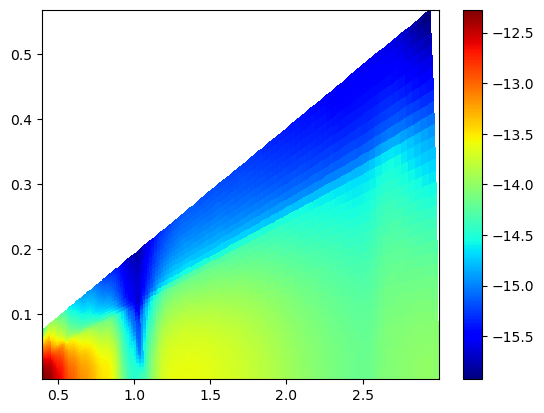

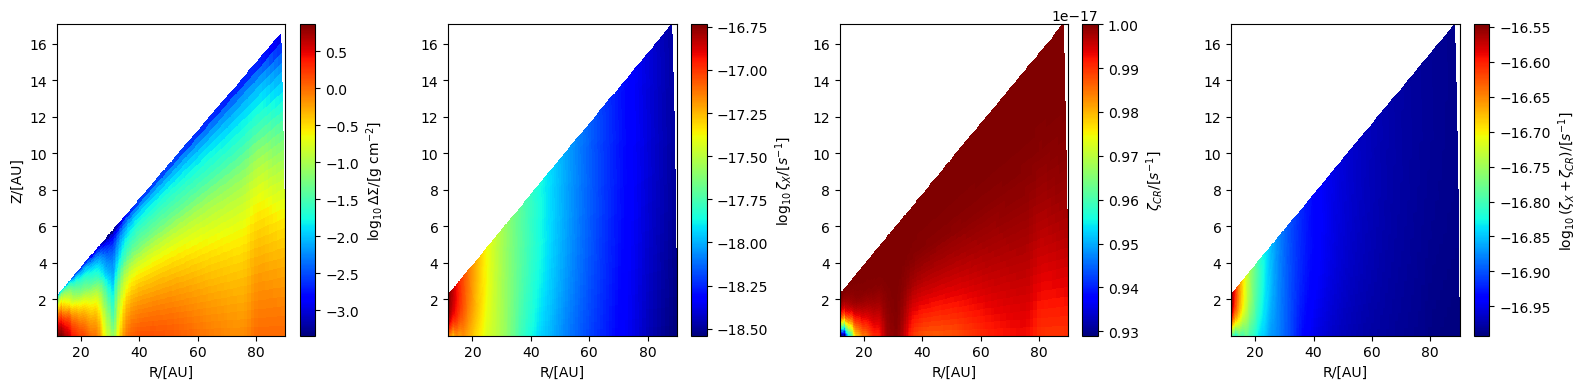

In [71]:
# Set case variables
T    = T_gap
rho  = rho_gap
ntot = ntot_gap
invsqrtT = 1e0 / np.sqrt(T)

AU = 1.496e+13 # cm
fig = plt.figure()
im = plt.pcolormesh(Rcyl/(30*AU), Zcyl/(30*AU), np.log10(rho),cmap="jet")
plt.colorbar(im)


# Fixed parameters
zeta  = zeta_ion(Rcyl, Zcyl, rho, plot=True)   # Ionization rate
alpha = 3.0e-6 * invsqrtT           # [cm^3 s^-1] radiative recombination
beta  = np.full_like(alpha,3.0e-9)  # [cm^3 s^-1] recombination of M^+ with grain
gamma = 3.0e-11 * invsqrtT          # [cm^3 s^-1] grain-assisted recombination

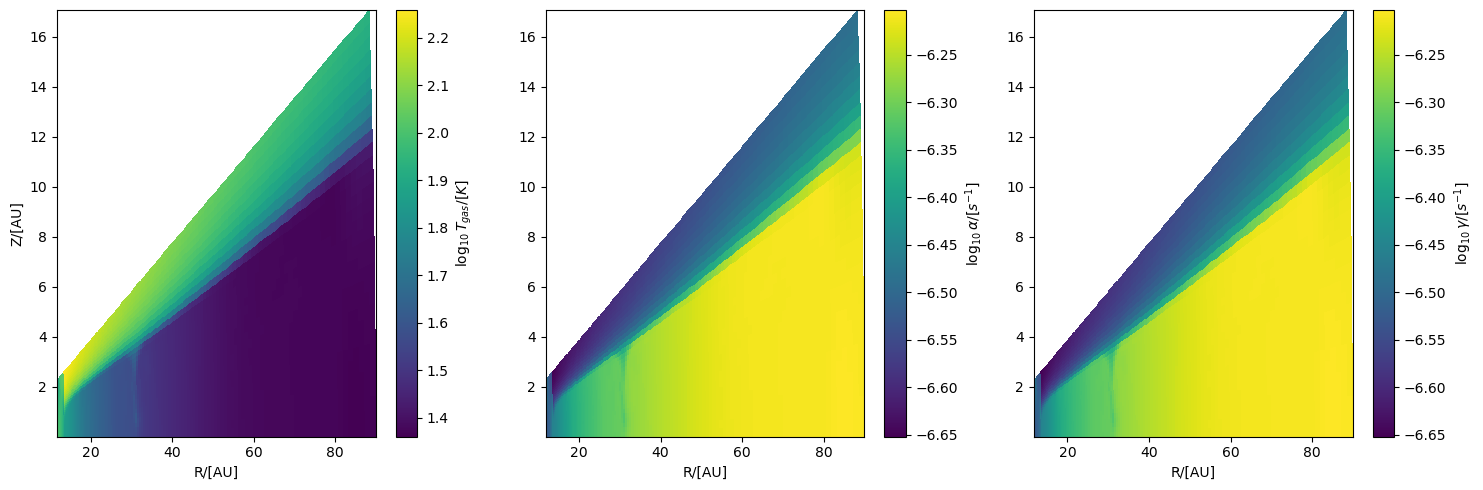

In [72]:
AU = 1.496e+13 # cm
fig = plt.figure(figsize=(15,5))
fig.add_subplot(131)
im1 = plt.pcolormesh(Rcyl/AU,Zcyl/AU,np.log10(T))
plt.xlabel("R/[AU]")
plt.ylabel("Z/[AU]")
plt.colorbar(im1,label=r"$\log_{10}T_{gas}/[K]$")

fig.add_subplot(132)
im2 = plt.pcolormesh(Rcyl/AU,Zcyl/AU,np.log10(alpha))
plt.xlabel("R/[AU]")
plt.colorbar(im2,label=r"$\log_{10}\alpha/[s^{-1}]$")

fig.add_subplot(133)
im2 = plt.pcolormesh(Rcyl/AU,Zcyl/AU,np.log10(alpha))
plt.xlabel("R/[AU]")
plt.colorbar(im2,label=r"$\log_{10}\gamma/[s^{-1}]$")

plt.tight_layout()
plt.show()

In [73]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))

for i in range(Nr):
    for j in range(Nz):
        n_i = np.zeros(nspecies)
        n_i[Species.e.value] = np.sqrt((zeta[i,j]*ntot[i, j])/alpha[i,j])
        n_i[Species.mp.value] = n_i[Species.e.value]
        n_i[Species.m.value] = ntot[i, j] - n_i[Species.mp.value]
        n_i[Species.M.value] = 0.0
        n_i[Species.Mp.value] = 0.0
        xsolver[i, j, :] = n_i

In [74]:
# Main loop
index = 0
ti = 0e0

# Output directory
path_out = "M_0_gap/"
os.makedirs(path_out, exist_ok=True)

while ti < t_orb:
    # Save output snapshot
    np.save(path_out + f"m_{index:03}.npy", xsolver[:, :, Species.m.value])
    np.save(path_out + f"mp_{index:03}.npy", xsolver[:, :, Species.mp.value])
    np.save(path_out + f"M_{index:03}.npy", xsolver[:, :, Species.M.value])
    np.save(path_out + f"Mp_{index:03}.npy", xsolver[:, :, Species.Mp.value])
    np.save(path_out + f"e_{index:03}.npy", xsolver[:, :, Species.e.value])
    index += 1

    # Update each cell
    for i in range(Nr):
        for j in range(Nz):
            ni = xsolver[i, j, :]        # mass fractions
            rhoi = rho[i, j]
            Tgasi = T[i, j]

            # ni = (Xi * rhoi) / mass_species
            delta_n = solver(ni, rhoi, Tgasi, dt, zeta[i, j])
            ni_new = ni + delta_n
            ni_new = np.maximum(ni_new, 1e-30)
            xsolver[i, j, :] = ni_new

    # Advance time
    ti += dt

### $X_{M}=10^{-13}$

In [75]:
# Initial xM
xM = 1e-13

In [ ]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))
count = 0
for i in range(Nr):
    for j in range(Nz):
        
        a = 1.0
        b = (beta[i, j] * xM) / alpha[i, j]
        c = - zeta[i,j] / (alpha[i, j] * ntot[i, j])
        d = - (beta[i, j] * zeta[i,j] * xM) / (alpha[i, j] * gamma[i, j] * ntot[i, j])

        # Solve cubic equation: a x^3 + b x^2 + c x + d = 0
        coeffs = [a, b, c, d]
        roots = np.roots(coeffs)
        real_roots = [r.real for r in roots if np.isreal(r) and r.real > 0]

        xe = np.real(roots[np.isreal(roots) & (np.real(roots) > 0)][0])  # Choose the smallest positive root

        # Compare with the analytical solution
        xe_a = np.sqrt(zeta[i,j]/(alpha[i,j]*ntot[i, j]))
        dxe = np.abs(xe - xe_a)/xe_a
        if dxe > 1e-11:
            count += 1

        # xe_num = np.sqrt(zeta[i,j]/(alpha[i,j]*n_i[Species.m.value]))

        # Initialize species number densities
        n_i = np.zeros(nspecies)
        n_i[Species.m.value]  = ntot[i, j]  # neutrals
        n_i[Species.e.value]  = xe * ntot[i, j]
        n_i[Species.mp.value] = zeta[i,j] / (alpha[i,j] * xe + beta[i,j] * xM)
        n_i[Species.M.value]  = xM * ntot[i, j]
        n_i[Species.Mp.value] = n_i[Species.e.value] - n_i[Species.mp.value]

        # Check if the solution is valid
        if np.any(n_i < 0):
            print(f"Negative number density at cell ({i}, {j})")
        
        # Store in solver array
        xsolver[i, j, :] = n_i

# print(f"Cubic solutions differ at {count} out of {Nr*Nz}")

In [77]:
# Main loop
index = 0
ti = 0e0

# Output directory
path_out = "xM-13_gap/"
os.makedirs(path_out, exist_ok=True)

while ti < t_orb/10:
    # Save output snapshot
    np.save(path_out + f"m_{index:03}.npy", xsolver[:, :, Species.m.value])
    np.save(path_out + f"mp_{index:03}.npy", xsolver[:, :, Species.mp.value])
    np.save(path_out + f"M_{index:03}.npy", xsolver[:, :, Species.M.value])
    np.save(path_out + f"Mp_{index:03}.npy", xsolver[:, :, Species.Mp.value])
    np.save(path_out + f"e_{index:03}.npy", xsolver[:, :, Species.e.value])
    index += 1

    # Update each cell
    for i in range(Nr):
        for j in range(Nz):
            ni = xsolver[i, j, :]        # mass fractions
            rhoi = rho[i, j]
            Tgasi = T[i, j]

            # ni = (Xi * rhoi) / mass_species
            delta_n = solver(ni, rhoi, Tgasi, dt, zeta[i, j])
            ni_new = ni + delta_n
            ni_new = np.maximum(ni_new, 1e-30)
            xsolver[i, j, :] = ni_new

    # Advance time
    ti += dt

### $X_{M} = 10^{-12}$

In [78]:
# Initial xM
xM = 1e-12

In [ ]:
# Initialize solver array (mass fractions): shape = (Nr, Nz, nspecies)
xsolver = np.zeros((Nr, Nz, nspecies))
count = 0
for i in range(Nr):
    for j in range(Nz):
        
        a = 1.0
        b = (beta[i, j] * xM) / alpha[i, j]
        c = - zeta[i,j] / (alpha[i, j] * ntot[i, j])
        d = - (beta[i, j] * zeta[i,j] * xM) / (alpha[i, j] * gamma[i, j] * ntot[i, j])

        # Solve cubic equation: a x^3 + b x^2 + c x + d = 0
        coeffs = [a, b, c, d]
        roots = np.roots(coeffs)
        real_roots = [r.real for r in roots if np.isreal(r) and r.real > 0]

        xe = np.real(roots[np.isreal(roots) & (np.real(roots) > 0)][0])  # Choose the smallest positive root

        # Compare with the analytical solution
        xe_a = np.sqrt(zeta[i,j]/(alpha[i,j]*ntot[i, j]))
        dxe = np.abs(xe - xe_a)/xe_a
        if dxe > 1e-11:
            count += 1

        # xe_num = np.sqrt(zeta[i,j]/(alpha[i,j]*n_i[Species.m.value]))

        # Initialize species number densities
        n_i = np.zeros(nspecies)
        n_i[Species.m.value]  = ntot[i, j]  # neutrals
        n_i[Species.e.value]  = xe * ntot[i, j]
        n_i[Species.mp.value] = zeta[i,j] / (alpha[i,j] * xe + beta[i,j] * xM)
        n_i[Species.M.value]  = xM * ntot[i, j]
        n_i[Species.Mp.value] = n_i[Species.e.value] - n_i[Species.mp.value]

        # Check if the solution is valid
        if np.any(n_i < 0):
            print(f"Negative number density at cell ({i}, {j})")
        
        # Store in solver array
        xsolver[i, j, :] = n_i

# print(f"Cubic solutions differ at {count} out of {Nr*Nz}")

In [80]:
# Main loop
index = 0
ti = 0e0

# Output directory
path_out = "xM-12_gap/"
os.makedirs(path_out, exist_ok=True)

while ti < t_orb:
    # Save output snapshot
    np.save(path_out + f"m_{index:03}.npy", xsolver[:, :, Species.m.value])
    np.save(path_out + f"mp_{index:03}.npy", xsolver[:, :, Species.mp.value])
    np.save(path_out + f"M_{index:03}.npy", xsolver[:, :, Species.M.value])
    np.save(path_out + f"Mp_{index:03}.npy", xsolver[:, :, Species.Mp.value])
    np.save(path_out + f"e_{index:03}.npy", xsolver[:, :, Species.e.value])
    index += 1

    # Update each cell
    for i in range(Nr):
        for j in range(Nz):
            ni = xsolver[i, j, :]        # mass fractions
            rhoi = rho[i, j]
            Tgasi = T[i, j]

            # ni = (Xi * rhoi) / mass_species
            delta_n = solver(ni, rhoi, Tgasi, dt, zeta[i, j])
            ni_new = ni + delta_n
            ni_new = np.maximum(ni_new, 1e-30)
            xsolver[i, j, :] = ni_new

    # Advance time
    ti += dt